In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import scipy.signal as signal
import numpy as np 
import scipy as sp
import pandas as pd

In [7]:
# write in the files 
hydrogen_file = "hydrogen_3_2.txt"
mystery_file = "mystery_3.txt"
dark_file = "dark_3.txt"

# define function to read and process the data
def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_start_index = next(i for i, line in enumerate(lines) if ">>>>>Begin Spectral Data<<<<<" in line) + 1
    spectral_data = pd.read_csv(
        file_path,
        skiprows=data_start_index,
        delim_whitespace=True,
        names=["Wavelength", "Intensity"],
        comment='>'
    )
    return spectral_data

# loading the data
hydrogen_data = load_data(hydrogen_file)
mystery_data = load_data(mystery_file)
dark_data = load_data(dark_file)

# remove the dark noise 
hydrogen_corrected = hydrogen_data.copy()
mystery_corrected = mystery_data.copy()
hydrogen_corrected["Intensity"] -= dark_data["Intensity"]
mystery_corrected["Intensity"] -= dark_data["Intensity"]


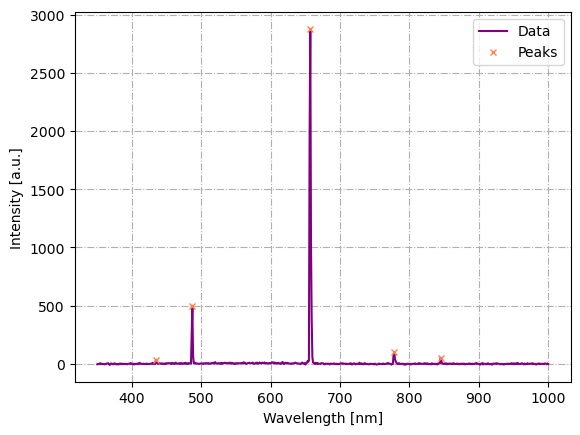

In [11]:
# wavelength and intensity for hydrogen 
wavelength = hydrogen_corrected["Wavelength"].values
intensity = hydrogen_corrected["Intensity"].values

# finding the number of peaks
peaks = sp.signal.find_peaks(intensity, prominence = 20)[0]
num_peaks = len(peaks)
plt.figure()
plt.plot(wavelength, intensity, color = 'purple', label = 'Data')
plt.plot(wavelength[peaks], intensity[peaks], color = 'coral', ls = '',
         marker = 'x',  ms = 5, label = 'Peaks')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [a.u.]')
plt.legend(loc = 'best', fontsize = 10)
plt.grid(ls = '-.')
plt.show()

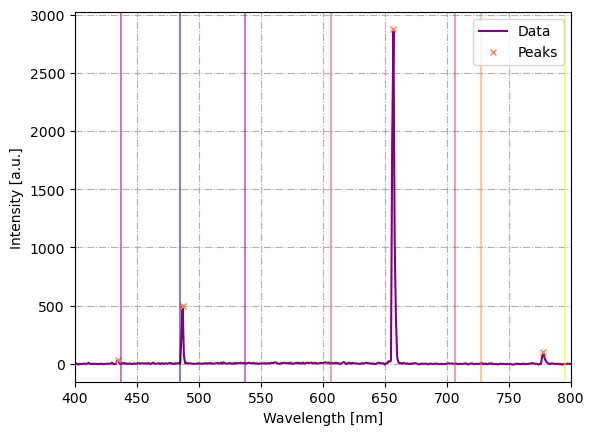

In [12]:
# finding the centeroid 

# defining the function for the centeroid 
def centroid(x, I):
  '''
  Returns the centroid value for a given set of x- and intensity values.

  Input: x: x values, I: intensity values
  Output: centroid value
  '''

  return np.sum(x*I)/np.sum(I)

plt.figure()

range_val = 50

colours = cm.plasma(np.linspace(0, 1, num_peaks))

plt.plot(wavelength, intensity, color = 'purple', label = 'Data')
plt.plot(wavelength[peaks], intensity[peaks], color = 'coral', ls = '',
         marker = 'x',  ms = 5, label = 'Peaks')

[plt.axvline(wavelength[peaks[i]-range_val], color = colours[i], alpha = 0.5)
for i in range(len(peaks))]

[plt.axvline(wavelength[peaks[i]+range_val], color = colours[i], alpha = 0.5)
for i in range(len(peaks))]

plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [a.u.]')

plt.legend(loc = 'best', fontsize = 10)
plt.grid(ls = '-.')
plt.xlim((400, 800))
plt.show()

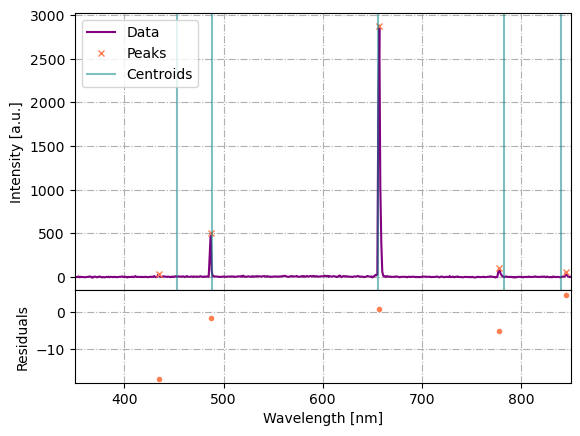

In [13]:
centroids = [centroid(wavelength[peaks[i]-range_val:peaks[i]+range_val], intensity[peaks[i]-range_val:peaks[i]+range_val]) for i in range(len(peaks))]

fig = plt.figure()

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace = 0.0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)

ax0.plot(wavelength, intensity, color = 'purple', label = 'Data')
ax0.plot(wavelength[peaks], intensity[peaks], color = 'coral', ls = '', marker = 'x',
         ms = 5, label = 'Peaks')

[ax0.axvline(c, color = 'teal', alpha = 0.5, label = 'Centroids') if c == centroids[0]
 else ax0.axvline(c, color = 'teal', alpha = 0.5) for c in centroids]

ax1.plot(wavelength[peaks], wavelength[peaks] - centroids, ls = '', marker = '.', color = 'coral')

ax1.set_xlabel('Wavelength [nm]')
ax0.set_ylabel('Intensity [a.u.]')
ax1.set_ylabel('Residuals')

plt.setp(ax0.get_xticklabels(), visible = False)

ax0.legend(loc = 'best', fontsize = 10)
ax0.grid(ls = '-.')
ax1.grid(ls = '-.')
plt.xlim((350, 850))
plt.show()

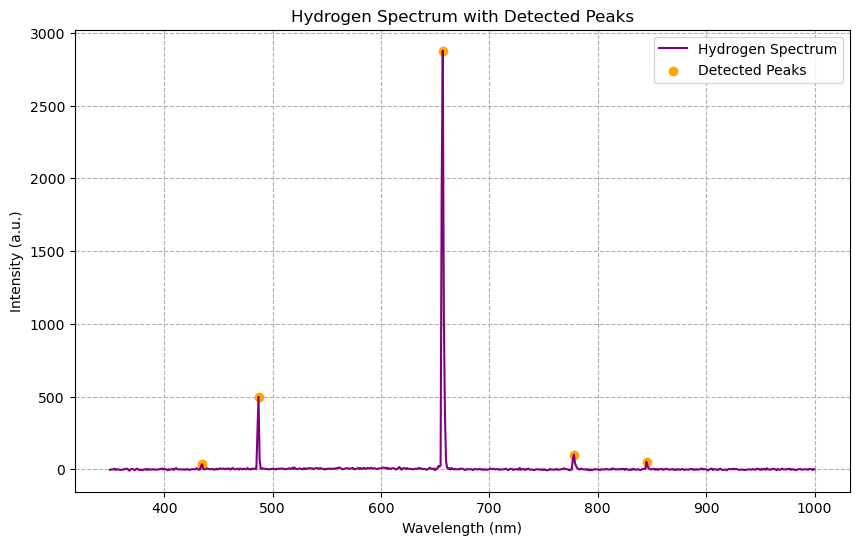

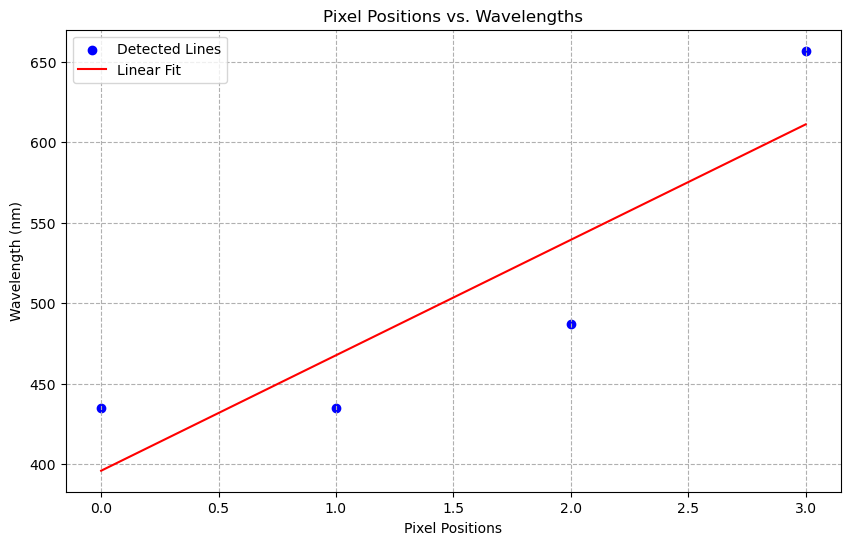

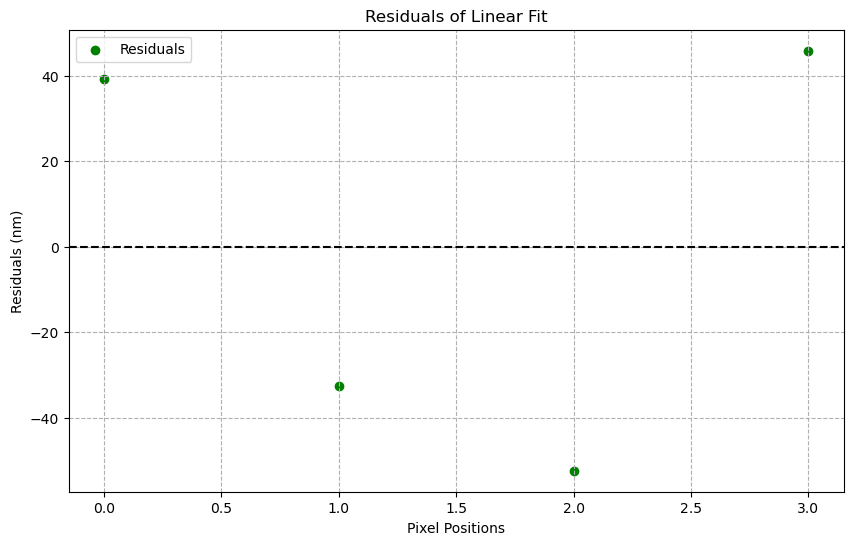

In [15]:
peak_wavelengths = wavelength[peaks]

# Known hydrogen wavelengths from NIST database
# These correspond to the Balmer series within 350-700 nm
known_hydrogen_lines = [410.17, 434.05, 486.13, 656.28]  # Wavelengths in nm

# Match known lines to detected peaks
detected_lines = []
for line in known_hydrogen_lines:
    closest_peak = peak_wavelengths[np.argmin(np.abs(peak_wavelengths - line))]
    detected_lines.append(closest_peak)

# Convert detected lines to pixel positions
pixel_positions = np.arange(len(detected_lines))

# Perform a linear fit
linear_coeffs = np.polyfit(pixel_positions, detected_lines, 1)
linear_fit = np.poly1d(linear_coeffs)

# Calculate residuals
residuals = np.array(detected_lines) - linear_fit(pixel_positions)

# Plot hydrogen spectrum with peaks
plt.figure(figsize=(10, 6))
plt.plot(wavelength, intensity, label="Hydrogen Spectrum", color='purple')
plt.scatter(peak_wavelengths, intensity[peaks], color='orange', label="Detected Peaks")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Hydrogen Spectrum with Detected Peaks")
plt.legend()
plt.grid(ls="--")
plt.show()

# Plot known wavelengths vs pixel positions
plt.figure(figsize=(10, 6))
plt.scatter(pixel_positions, detected_lines, color='blue', label="Detected Lines")
plt.plot(pixel_positions, linear_fit(pixel_positions), color='red', label="Linear Fit")
plt.xlabel("Pixel Positions")
plt.ylabel("Wavelength (nm)")
plt.title("Pixel Positions vs. Wavelengths")
plt.legend()
plt.grid(ls="--")
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(pixel_positions, residuals, color='green', label="Residuals")
plt.axhline(0, color='black', linestyle="--")
plt.xlabel("Pixel Positions")
plt.ylabel("Residuals (nm)")
plt.title("Residuals of Linear Fit")
plt.legend()
plt.grid(ls="--")
plt.show()

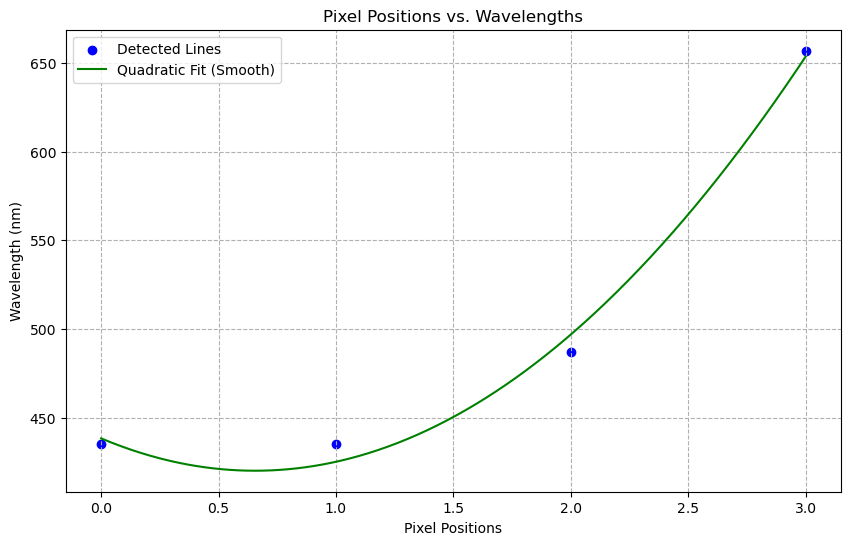

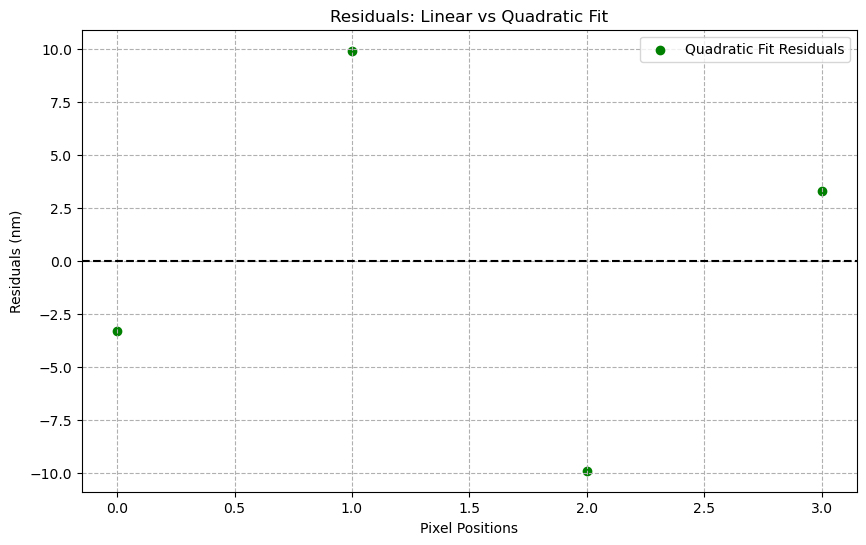

In [18]:
# Perform a quadratic fit
quadratic_coeffs = np.polyfit(pixel_positions, detected_lines, 2)
quadratic_fit = np.poly1d(quadratic_coeffs)
quadratic_residuals = np.array(detected_lines) - quadratic_fit(pixel_positions)
fine_pixel_positions = np.linspace(min(pixel_positions), max(pixel_positions), 500)

# Plot known wavelengths vs pixel positions with fits
plt.figure(figsize=(10, 6))
plt.scatter(pixel_positions, detected_lines, color='blue', label="Detected Lines")
#plt.plot(pixel_positions, linear_fit(pixel_positions), color='red', label="Linear Fit")
plt.plot(fine_pixel_positions, quadratic_fit(fine_pixel_positions), color='green', label="Quadratic Fit")
plt.xlabel("Pixel Positions")
plt.ylabel("Wavelength (nm)")
plt.title("Pixel Positions vs. Wavelengths")
plt.legend()
plt.grid(ls="--")
plt.show()

# Plot residuals for linear and quadratic fits
plt.figure(figsize=(10, 6))
#plt.scatter(pixel_positions, linear_residuals, color='red', label="Linear Fit Residuals")
plt.scatter(pixel_positions, quadratic_residuals, color='green', label="Quadratic Fit Residuals")
plt.axhline(0, color='black', linestyle="--")
plt.xlabel("Pixel Positions")
plt.ylabel("Residuals (nm)")
plt.title("Residuals: Linear vs Quadratic Fit")
plt.legend()
plt.grid(ls="--")
plt.show()

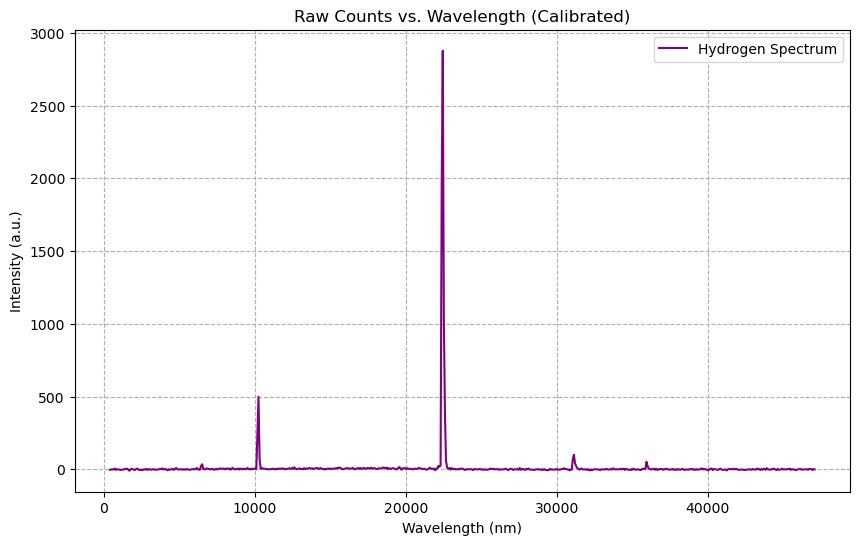

In [19]:
# Calibrate the wavelength for all pixel positions
all_pixel_positions = np.arange(len(wavelength))  # Assuming pixels correspond to indices
calibrated_wavelengths = linear_fit(all_pixel_positions)

# Plot the raw counts against calibrated wavelengths
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wavelengths, intensity, color='purple', label="Hydrogen Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Raw Counts vs. Wavelength (Calibrated)")
plt.legend()
plt.grid(ls="--")
plt.show()

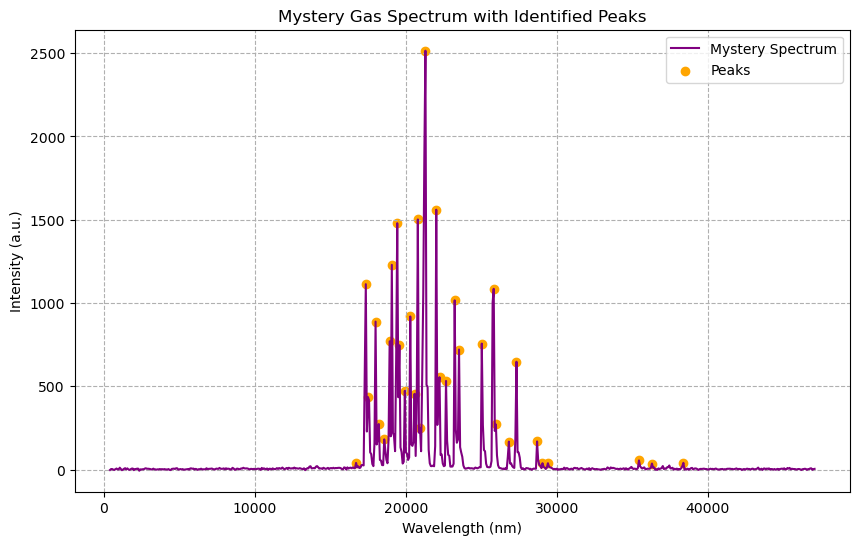

In [23]:
# Load the mystery gas spectrum
mystery_file = "mystery_3.txt"
mystery_data = load_data(mystery_file)

# Dark correction for the mystery spectrum
mystery_corrected = mystery_data.copy()
mystery_corrected["Intensity"] -= dark_data["Intensity"]

# Extract wavelength and intensity for the mystery gas
mystery_wavelength = mystery_corrected["Wavelength"].values
mystery_intensity = mystery_corrected["Intensity"].values

# Calibrate the wavelength for the mystery spectrum
calibrated_mystery_wavelengths = linear_fit(np.arange(len(mystery_wavelength)))

# Find peaks in the mystery spectrum
mystery_peaks = signal.find_peaks(mystery_intensity, prominence=25)[0]
mystery_peak_wavelengths = calibrated_mystery_wavelengths[mystery_peaks]

# Plot the mystery spectrum
plt.figure(figsize=(10, 6))
plt.plot(calibrated_mystery_wavelengths, mystery_intensity, color='purple', label="Mystery Spectrum")
plt.scatter(mystery_peak_wavelengths, mystery_intensity[mystery_peaks], color='orange', label="Peaks")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Mystery Gas Spectrum with Identified Peaks")
plt.legend()
plt.grid(ls="--")
plt.show()

# Compare mystery peaks to known atomic line wavelengths
# Example: Known atomic lines for common gases (in nm)
# Replace or extend this list with specific lines from a reliable source like NIST
known_lines = {
    "Hydrogen": [410.17, 434.05, 486.13, 656.28],
    "Helium": [447.15, 468.57, 587.56, 667.82],
    "Neon": [540.06, 585.25, 640.22, 703.24],
    "Argon": [696.54, 706.72, 738.40, 763.51],
}

# Identify the mystery gas by matching detected peaks to known lines
detected_gas = {}
for gas, lines in known_lines.items():
    matches = []
    for line in lines:
        closest_peak = mystery_peak_wavelengths[np.argmin(np.abs(mystery_peak_wavelengths - line))]
        if np.abs(closest_peak - line) < 10:  # Tolerance of 1 nm
            matches.append(closest_peak)
    if matches:
        detected_gas[gas] = matches

# Print the results
for gas, matches in detected_gas.items():
    print(f"Possible gas: {gas}")
    print(f"Matched lines: {matches}")
